# get_color_hex-manual_changes
The purpose of this notebook is to figure out how to obtain the color hex strings for segment ids given a colorseed in Python. This notebook also explores what happens if the colors are manually changed by the user in Neuroglancer. 

In [19]:
import neuroglancer
import math
import matplotlib.pyplot as plt
%matplotlib inline

In [7]:
neuroglancer.set_static_content_source(url='https://nglancer.pni.princeton.edu')
# neuroglancer.set_static_content_source(url='http://localhost:8080')
viewer = neuroglancer.Viewer()
with viewer.txn() as s:
    s.layers['atlas'] = neuroglancer.SegmentationLayer(source='precomputed://http://localhost:1338'
    )
print(viewer)

http://127.0.0.1:44598/v/cd207cd835ea6bdffe225738e20694eabe285cce/


In [6]:
def hash_function(state,value):
    """ Python implementation of hashCombine() function
    in src/neuroglancer/gpu_hash/hash_function.ts,
    a modified murmur hash
    """
    k1 = 0xcc9e2d51
    k2 = 0x1b873593
    state = state & 0xffffffff
    value = (value * k1) & 0xffffffff
    value = ((value << 15) | value >> 17) & 0xffffffff
    value = (value * k2) & 0xffffffff
    state = (state ^ value) & 0xffffffff
    state = (( state << 13) | state >> 19) & 0xffffffff
    state = (( state * 5) + 0xe6546b64) & 0xffffffff
    return state

def hsv_to_rgb(h,s,v):
    """ Convert H,S,V values to RGB values.
    Python implementation of hsvToRgb in src/neuroglancer/util/colorspace.ts """
    h*=6
    hue_index = math.floor(h)
    remainder = h - hue_index
    val1 = v*(1-s)
    val2 = v*(1-(s*remainder))
    val3 = v*(1-(s*(1-remainder)))
    hue_remainder = hue_index % 6
    if hue_remainder == 0:
        return (v,val3,val1)
    elif hue_remainder == 1:
        return (val2,v,val1)
    elif hue_remainder == 2:
        return (val1,v,val3)
    elif hue_remainder == 3:
        return (val1,val2,v)
    elif hue_remainder == 4:
        return (val3,val1,v)
    elif hue_remainder == 5: 
        return (v,val1,val2)   

def pack_color(rgb_vec):
    """ Returns an integer formed
    by concatenating the channels of the input color vector.
    Python implementation of packColor in src/neuroglancer/util/color.ts
    """
    result = 0
    for i in range(len(rgb_vec)):
        result = ((result << 8) & 0xffffffff) + min(255,max(0,round(rgb_vec[i]*255)))
    return result

def hex_string_from_segment_id(color_seed,segment_id):
    """ Return the hex color string for a segment
    given a color seed and the segment id """
    segment_id = int(segment_id) # necessary since segment_id is 64 bit originally 
    result = hash_function(state=color_seed,value=segment_id)
    newvalue = segment_id >> 32
    result2 = hash_function(state=result,value=newvalue)
    c0 = (result2 & 0xFF) / 255.
    c1 = ((result2 >> 8) & 0xFF) / 255.;
    h = c0
    s =  0.5 + 0.5 * c1
    v = 1.0
    rgb=hsv_to_rgb(h,s,v)
    packed_color = pack_color(rgb_vec=rgb)
    hex_string = format(packed_color, 'x')
    """ Zero pad the hex string if less than 6 characeters """
    if len(hex_string) < 6:
        hex_string = '0'*(6-len(hex_string)) + hex_string
    hex_string = '#' + hex_string
    return hex_string

Colors of your segments are:
{'149': '#10b3ff', '189': '#0effb2', '59': '#ff359e', '599': '#ffe55a'}

Plot to verify colors:


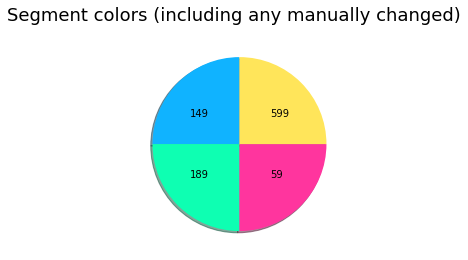

In [97]:
# Run this code block after you change your colors and want to retrieve the color dictionary
with viewer.txn() as s:
    seglayer = s.layers['atlas'].layer
    seg_dict = seglayer.to_json()
    color_seed = seg_dict['colorSeed']
    active_segments=list(seg_dict['segments'])
    try:
        manual_segment_dict = seg_dict['segmentColors']
    except:
        manual_segment_dict = {}
# Now fill a dictionary where
# keys will be segment id, values will be hex color string
# taking the manually set value over the original one if present
hex_str_dict = {}
for segment_id in active_segments:
    if segment_id in manual_segment_dict:
        hex_str_dict[segment_id] = manual_segment_dict[segment_id]
    else:
        hex_str_dict[segment_id] = hex_string_from_segment_id(color_seed,segment_id)
print("Colors of your segments are:")
print(hex_str_dict)
print()
print("Plot to verify colors:")
sizes = [360/float(len(active_segments)) for x in active_segments]

fig1, ax1 = plt.subplots()
pie=ax1.pie(sizes,labels=hex_str_dict.keys(),labeldistance=0.5,
        shadow=True, startangle=90,colors=hex_str_dict.values())
title=fig1.suptitle('Segment colors (including any manually changed)',fontsize=18)